In [1]:
# Import all necessary packages

# Supporting
import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.8"  # 0.9 causes too much lag.
import functools
from datetime import datetime
from etils import epath
from typing import Any, Sequence, List
from ml_collections import config_dict
import matplotlib.pyplot as plt

# Math
import jax
import jax.numpy as jp
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)  # More legible printing from numpy.
from jax import config  # Analytical gradients work much better with double precision.
# config.update("jax_debug_nans", True)
# config.update("jax_enable_x64", True)
# config.update('jax_default_matmul_precision', 'high')
from flax.training import orbax_utils
from orbax import checkpoint as ocp

# Sim
import mujoco

# Brax
from brax import base
from brax import envs
from brax import math
from brax.base import Motion, Transform
from brax.envs.base import PipelineEnv, State
from brax.io import mjcf, model

# Algorithm
from brax.training.agents.ppo import train as ppo
from brax.training.agents.ppo import networks as ppo_networks

In [2]:
# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

In [3]:
# Checking that mujoco installation succeeded
mujoco.MjModel.from_xml_string(xml='<mujoco/>')

In [4]:
def domain_randomize(sys, rng):
  """Randomizes the mjx.Model."""
  @jax.vmap
  def rand(rng):
    _, key = jax.random.split(rng, 2)
    # friction
    friction = jax.random.uniform(key, (1,), minval=0.6, maxval=1.4)
    friction = sys.geom_friction.at[:, 0].set(friction)
    # actuator
    _, key = jax.random.split(key, 2)
    gain_range = (-5, 5)
    param = jax.random.uniform(
        key, (1,), minval=gain_range[0], maxval=gain_range[1]
    ) + sys.actuator_gainprm[:, 0]
    gain = sys.actuator_gainprm.at[:, 0].set(param)
    bias = sys.actuator_biasprm.at[:, 1].set(-param)
    return friction, gain, bias

  friction, gain, bias = rand(rng)

  in_axes = jax.tree_util.tree_map(lambda x: None, sys)
  in_axes = in_axes.tree_replace({
      'geom_friction': 0,
      'actuator_gainprm': 0,
      'actuator_biasprm': 0,
  })

  sys = sys.tree_replace({
      'geom_friction': friction,
      'actuator_gainprm': gain,
      'actuator_biasprm': bias,
  })

  return sys, in_axes

In [5]:
#@title Unitree Go2 Quadruped Env
menagerie_path = '../../assets/Unitree_GO2/'
GO2_ROOT_PATH = epath.Path(menagerie_path)


def get_config():
  """Returns reward config for barkour quadruped environment."""

  def get_default_rewards_config():
    default_config = config_dict.ConfigDict(
        dict(
            # The coefficients for all reward terms used for training. All
            # physical quantities are in SI units, if no otherwise specified,
            # i.e. joint positions are in rad, positions are measured in meters,
            # torques in Nm, and time in seconds, and forces in Newtons.
            scales=config_dict.ConfigDict(
                dict(
                    # Tracking rewards are computed using exp(-delta^2/sigma)
                    # sigma can be a hyperparameters to tune.
                    # Track the base x-y velocity (no z-velocity tracking.)
                    tracking_lin_vel=1.5,
                    # Track the angular velocity along z-axis, i.e. yaw rate.
                    tracking_ang_vel=0.8,
                    # Below are regularization terms, we roughly divide the
                    # terms to base state regularizations, joint
                    # regularizations, and other behavior regularizations.
                    # Penalize the base velocity in z direction, L2 penalty.
                    lin_vel_z=-2.0,
                    # Penalize the base roll and pitch rate. L2 penalty.
                    ang_vel_xy=-0.05,
                    # Penalize non-zero roll and pitch angles. L2 penalty.
                    orientation=-5.0,
                    # L2 regularization of joint torques, |tau|^2.
                    torques=-0.0002,
                    # Penalize the change in the action and encourage smooth
                    # actions. L2 regularization |action - last_action|^2
                    action_rate=-0.01,
                    # Encourage long swing steps.  However, it does not
                    # encourage high clearances.
                    feet_air_time=0.2,
                    # Encourage no motion at zero command, L2 regularization
                    # |q - q_default|^2.
                    stand_still=-0.5,
                    # Early termination penalty.
                    termination=-1.0,
                    # Penalizing foot slipping on the ground.
                    foot_slip=-0.1,
                )
            ),
            # Tracking reward = exp(-error^2/sigma).
            tracking_sigma=0.25,
        )
    )
    return default_config

  default_config = config_dict.ConfigDict(
      dict(
          rewards=get_default_rewards_config(),
      )
  )

  return default_config


class Go2JoystickEnv(PipelineEnv):
  """Environment for training the go2 quadruped joystick policy in MJX."""

  def __init__(
      self,
      obs_noise: float = 0.05,
      action_scale: float = 0.3,
      kick_vel: float = 0.05,
      scene_file: str = 'scene_mjx.xml',
      **kwargs,
  ):
    path = GO2_ROOT_PATH / scene_file
    sys = mjcf.load(path.as_posix())
    self._dt = 0.02  # this environment is 50 fps
    sys = sys.tree_replace({'opt.timestep': 0.004})

    n_frames = kwargs.pop('n_frames', int(self._dt / sys.opt.timestep))
    super().__init__(sys, backend='mjx', n_frames=n_frames)

    self.reward_config = get_config()
    # set custom from kwargs
    for k, v in kwargs.items():
      if k.endswith('_scale'):
        self.reward_config.rewards.scales[k[:-6]] = v

    self._torso_idx = mujoco.mj_name2id(
        sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, 'base'
    )
    self._action_scale = action_scale
    self._obs_noise = obs_noise
    self._kick_vel = kick_vel
    self._init_q = jp.array(sys.mj_model.keyframe('home').qpos)
    self._default_pose = sys.mj_model.keyframe('home').qpos[7:]
    self.lowers = jp.array([-0.7, -1.0, -2.2] * 4)
    self.uppers = jp.array([0.52, 2.1, -0.4] * 4)
    feet_site = [
        'FL_foot',
        'RL_foot',
        'FR_foot',
        'RR_foot',
    ]
    feet_site_id = [
        mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_SITE.value, f)
        for f in feet_site
    ]
    assert not any(id_ == -1 for id_ in feet_site_id), 'Site not found.'
    self._feet_site_id = np.array(feet_site_id)
    lower_leg_body = [
        'FL_calf',
        'RL_calf',
        'FR_calf',
        'RR_calf',
    ]
    lower_leg_body_id = [
        mujoco.mj_name2id(sys.mj_model, mujoco.mjtObj.mjOBJ_BODY.value, l)
        for l in lower_leg_body
    ]
    assert not any(id_ == -1 for id_ in lower_leg_body_id), 'Body not found.'
    self._lower_leg_body_id = np.array(lower_leg_body_id)
    self._foot_radius = 0.0175
    self._nv = sys.nv

  def sample_command(self, rng: jax.Array) -> jax.Array:
    lin_vel_x = [-0.6, 1.5]  # min max [m/s]
    lin_vel_y = [-0.8, 0.8]  # min max [m/s]
    ang_vel_yaw = [-0.7, 0.7]  # min max [rad/s]

    _, key1, key2, key3 = jax.random.split(rng, 4)
    lin_vel_x = jax.random.uniform(
        key1, (1,), minval=lin_vel_x[0], maxval=lin_vel_x[1]
    )
    lin_vel_y = jax.random.uniform(
        key2, (1,), minval=lin_vel_y[0], maxval=lin_vel_y[1]
    )
    ang_vel_yaw = jax.random.uniform(
        key3, (1,), minval=ang_vel_yaw[0], maxval=ang_vel_yaw[1]
    )
    new_cmd = jp.array([lin_vel_x[0], lin_vel_y[0], ang_vel_yaw[0]])
    # new_cmd = jp.array([1.0, 0.0, 0.0])
    return new_cmd

  def reset(self, rng: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, key = jax.random.split(rng)

    pipeline_state = self.pipeline_init(self._init_q, jp.zeros(self._nv))

    state_info = {
        'rng': rng,
        'last_act': jp.zeros(12),
        'last_vel': jp.zeros(12),
        'command': self.sample_command(key),
        'last_contact': jp.zeros(4, dtype=bool),
        'feet_air_time': jp.zeros(4),
        'rewards': {k: 0.0 for k in self.reward_config.rewards.scales.keys()},
        'kick': jp.array([0.0, 0.0]),
        'step': 0,
    }

    obs_history = jp.zeros(15 * 31)  # store 15 steps of history
    obs = self._get_obs(pipeline_state, state_info, obs_history)
    reward, done = jp.zeros(2)
    metrics = {'total_dist': 0.0}
    for k in state_info['rewards']:
      metrics[k] = state_info['rewards'][k]
    state = State(pipeline_state, obs, reward, done, metrics, state_info)  # pytype: disable=wrong-arg-types
    return state

  def step(self, state: State, action: jax.Array) -> State:  # pytype: disable=signature-mismatch
    rng, cmd_rng, kick_noise_2 = jax.random.split(state.info['rng'], 3)

    # kick
    push_interval = 10
    kick_theta = jax.random.uniform(kick_noise_2, maxval=2 * jp.pi)
    kick = jp.array([jp.cos(kick_theta), jp.sin(kick_theta)])
    kick *= jp.mod(state.info['step'], push_interval) == 0
    qvel = state.pipeline_state.qvel  # pytype: disable=attribute-error
    qvel = qvel.at[:2].set(kick * self._kick_vel + qvel[:2])
    state = state.tree_replace({'pipeline_state.qvel': qvel})

    # physics step
    motor_targets = self._default_pose + action * self._action_scale
    motor_targets = jp.clip(motor_targets, self.lowers, self.uppers)
    # jax.debug.print('motor_targets: {target}', target=motor_targets)
    pipeline_state = self.pipeline_step(state.pipeline_state, motor_targets)
    x, xd = pipeline_state.x, pipeline_state.xd

    # observation data
    obs = self._get_obs(pipeline_state, state.info, state.obs)
    joint_angles = pipeline_state.q[7:]
    joint_vel = pipeline_state.qd[6:]

    # foot contact data based on z-position
    foot_pos = pipeline_state.site_xpos[self._feet_site_id]  # pytype: disable=attribute-error
    foot_contact_z = foot_pos[:, 2] - self._foot_radius
    contact = foot_contact_z < 1e-3  # a mm or less off the floor
    contact_filt_mm = contact | state.info['last_contact']
    contact_filt_cm = (foot_contact_z < 3e-2) | state.info['last_contact']
    first_contact = (state.info['feet_air_time'] > 0) * contact_filt_mm
    state.info['feet_air_time'] += self.dt

    # done if joint limits are reached or robot is falling
    up = jp.array([0.0, 0.0, 1.0])
    done = jp.dot(math.rotate(up, x.rot[self._torso_idx - 1]), up) < 0
    done |= jp.any(joint_angles < self.lowers)
    done |= jp.any(joint_angles > self.uppers)
    done |= pipeline_state.x.pos[self._torso_idx - 1, 2] < 0.18

    # reward
    rewards = {
        'tracking_lin_vel': (
            self._reward_tracking_lin_vel(state.info['command'], x, xd)
        ),
        'tracking_ang_vel': (
            self._reward_tracking_ang_vel(state.info['command'], x, xd)
        ),
        'lin_vel_z': self._reward_lin_vel_z(xd),
        'ang_vel_xy': self._reward_ang_vel_xy(xd),
        'orientation': self._reward_orientation(x),
        'torques': self._reward_torques(pipeline_state.qfrc_actuator),  # pytype: disable=attribute-error
        'action_rate': self._reward_action_rate(action, state.info['last_act']),
        'stand_still': self._reward_stand_still(
            state.info['command'], joint_angles,
        ),
        'feet_air_time': self._reward_feet_air_time(
            state.info['feet_air_time'],
            first_contact,
            state.info['command'],
        ),
        'foot_slip': self._reward_foot_slip(pipeline_state, contact_filt_cm),
        'termination': self._reward_termination(done, state.info['step']),
    }
    rewards = {
        k: v * self.reward_config.rewards.scales[k] for k, v in rewards.items()
    }
    reward = jp.clip(sum(rewards.values()) * self.dt, 0.0, 10000.0)

    # state management
    state.info['kick'] = kick
    state.info['last_act'] = action
    state.info['last_vel'] = joint_vel
    state.info['feet_air_time'] *= ~contact_filt_mm
    state.info['last_contact'] = contact
    state.info['rewards'] = rewards
    state.info['step'] += 1
    state.info['rng'] = rng

    # sample new command if more than 500 timesteps achieved
    state.info['command'] = jp.where(
        state.info['step'] > 500,
        self.sample_command(cmd_rng),
        state.info['command'],
    )
    # reset the step counter when done
    state.info['step'] = jp.where(
        done | (state.info['step'] > 500), 0, state.info['step']
    )

    # log total displacement as a proxy metric
    state.metrics['total_dist'] = math.normalize(x.pos[self._torso_idx - 1])[1]
    state.metrics.update(state.info['rewards'])

    done = jp.float32(done)
    state = state.replace(
        pipeline_state=pipeline_state, obs=obs, reward=reward, done=done
    )
    return state

  def _get_obs(
      self,
      pipeline_state: base.State,
      state_info: dict[str, Any],
      obs_history: jax.Array,
  ) -> jax.Array:
    inv_torso_rot = math.quat_inv(pipeline_state.x.rot[0])
    local_rpyrate = math.rotate(pipeline_state.xd.ang[0], inv_torso_rot)

    obs = jp.concatenate([
        jp.array([local_rpyrate[2]]) * 0.25,                 # yaw rate
        math.rotate(jp.array([0, 0, -1]), inv_torso_rot),    # projected gravity
        state_info['command'] * jp.array([2.0, 2.0, 0.25]),  # command
        pipeline_state.q[7:] - self._default_pose,           # motor angles
        state_info['last_act'],                              # last action
    ])

    # clip, noise
    obs = jp.clip(obs, -100.0, 100.0) + self._obs_noise * jax.random.uniform(
        state_info['rng'], obs.shape, minval=-1, maxval=1
    )
    # stack observations through time
    obs = jp.roll(obs_history, obs.size).at[:obs.size].set(obs)

    return obs

  # ------------ reward functions----------------
  def _reward_lin_vel_z(self, xd: Motion) -> jax.Array:
    # Penalize z axis base linear velocity
    return jp.square(xd.vel[0, 2])

  def _reward_ang_vel_xy(self, xd: Motion) -> jax.Array:
    # Penalize xy axes base angular velocity
    return jp.sum(jp.square(xd.ang[0, :2]))

  def _reward_orientation(self, x: Transform) -> jax.Array:
    # Penalize non flat base orientation
    up = jp.array([0.0, 0.0, 1.0])
    rot_up = math.rotate(up, x.rot[0])
    return jp.sum(jp.square(rot_up[:2]))

  def _reward_torques(self, torques: jax.Array) -> jax.Array:
    # Penalize torques
    return jp.sqrt(jp.sum(jp.square(torques))) + jp.sum(jp.abs(torques))

  def _reward_action_rate(
      self, act: jax.Array, last_act: jax.Array
  ) -> jax.Array:
    # Penalize changes in actions
    return jp.sum(jp.square(act - last_act))

  def _reward_tracking_lin_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of linear velocity commands (xy axes)
    local_vel = math.rotate(xd.vel[0], math.quat_inv(x.rot[0]))
    lin_vel_error = jp.sum(jp.square(commands[:2] - local_vel[:2]))
    lin_vel_reward = jp.exp(
        -lin_vel_error / self.reward_config.rewards.tracking_sigma
    )
    return lin_vel_reward

  def _reward_tracking_ang_vel(
      self, commands: jax.Array, x: Transform, xd: Motion
  ) -> jax.Array:
    # Tracking of angular velocity commands (yaw)
    base_ang_vel = math.rotate(xd.ang[0], math.quat_inv(x.rot[0]))
    ang_vel_error = jp.square(commands[2] - base_ang_vel[2])
    return jp.exp(-ang_vel_error / self.reward_config.rewards.tracking_sigma)

  def _reward_feet_air_time(
      self, air_time: jax.Array, first_contact: jax.Array, commands: jax.Array
  ) -> jax.Array:
    # Reward air time.
    rew_air_time = jp.sum((air_time - 0.1) * first_contact)
    rew_air_time *= (
        math.normalize(commands[:2])[1] > 0.05
    )  # no reward for zero command
    return rew_air_time

  def _reward_stand_still(
      self,
      commands: jax.Array,
      joint_angles: jax.Array,
  ) -> jax.Array:
    # Penalize motion at zero commands
    return jp.sum(jp.abs(joint_angles - self._default_pose)) * (
        math.normalize(commands[:2])[1] < 0.1
    )

  def _reward_foot_slip(
      self, pipeline_state: base.State, contact_filt: jax.Array
  ) -> jax.Array:
    # get velocities at feet which are offset from lower legs
    # pytype: disable=attribute-error
    pos = pipeline_state.site_xpos[self._feet_site_id]  # feet position
    feet_offset = pos - pipeline_state.xpos[self._lower_leg_body_id]
    # pytype: enable=attribute-error
    offset = base.Transform.create(pos=feet_offset)
    foot_indices = self._lower_leg_body_id - 1  # we got rid of the world body
    foot_vel = offset.vmap().do(pipeline_state.xd.take(foot_indices)).vel

    # Penalize large feet velocity for feet that are in contact with the ground.
    return jp.sum(jp.square(foot_vel[:, :2]) * contact_filt.reshape((-1, 1)))

  def _reward_termination(self, done: jax.Array, step: jax.Array) -> jax.Array:
    return done & (step < 500)

  def render(
      self, trajectory: List[base.State], camera: str | None = None,
      width: int = 240, height: int = 320,
  ) -> Sequence[np.ndarray]:
    camera = camera or 'track'
    return super().render(trajectory, camera=camera, width=width, height=height)

envs.register_environment('joystick_go2', Go2JoystickEnv)

## Test environment

In [6]:
env_name = 'joystick_go2'
env = envs.get_environment(env_name)

In [7]:
# define the jit reset/step functions
jit_reset = jax.jit(env.reset)
jit_step = jax.jit(env.step)

# initialize the state
state = jit_reset(jax.random.PRNGKey(0))
rollout = [state.pipeline_state]

# grab a trajectory
for i in range(100):
  ctrl = jp.zeros((12,))
  state = jit_step(state, ctrl)
  rollout.append(state.pipeline_state)

In [8]:
import mediapy as media

media.show_video(env.render(rollout), fps= 1.0/env.dt)

## Training with PPO

In [9]:
def progress(num_steps, metrics):
  times.append(datetime.now())
  x_data.append(num_steps)
  y_data.append(metrics['eval/episode_reward'])
  ydataerr.append(metrics['eval/episode_reward_std'])

  plt.xlim([0, train_fn.keywords['num_timesteps'] * 1.25])
  plt.ylim([min_y, max_y])

  plt.xlabel('# environment steps')
  plt.ylabel('reward per episode')
  plt.title(f'y={y_data[-1]:.3f}')

  plt.errorbar(
      x_data, y_data, yerr=ydataerr)
  plt.show()

2025-01-26 17:53:51.404850: E external/xla/xla/service/slow_operation_alarm.cc:73] Constant folding an instruction is taking > 1s:

  %maximum.31 = f32[140,8192,3]{2,1,0} maximum(f32[140,8192,3]{2,0,1} %constant.5256, f32[140,8192,3]{2,0,1} %constant.5261), metadata={op_name="jit(reset)/jit(main)/vmap(vmap(forward))/fwd_position/max" source_file="/tmp/ipykernel_61554/2622281796.py" source_line=156}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-01-26 17:53:51.700003: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.295240877s
Constant folding an instruction is taking > 1s:

  %maximum.31 = f32[140,8192,3]{

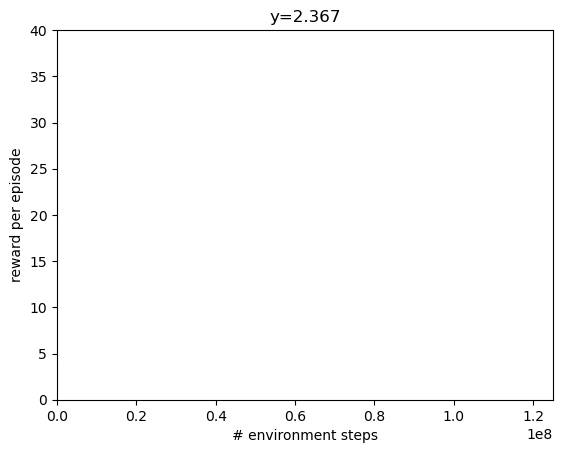

In [ ]:
ckpt_path = epath.Path('/home/kanghyunryu/DDAT/code/Unitree_GO2/ckpts')
ckpt_path.mkdir(parents=True, exist_ok=True)

def policy_params_fn(current_step, make_policy, params):
  # save checkpoints
  orbax_checkpointer = ocp.PyTreeCheckpointer()
  save_args = orbax_utils.save_args_from_target(params)
  path = ckpt_path / f'{current_step}'
  orbax_checkpointer.save(path, params, force=True, save_args=save_args)

make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128, 128))
train_fn = functools.partial(
      ppo.train, num_timesteps=100_000_000, num_evals=10,
      reward_scaling=1, episode_length=1000, normalize_observations=True,
      action_repeat=1, unroll_length=20, num_minibatches=32,
      num_updates_per_batch=4, discounting=0.97, learning_rate=3.0e-4,
      entropy_cost=1e-2, num_envs=8192, batch_size=256,
      network_factory=make_networks_factory,
      randomization_fn=domain_randomize,
      policy_params_fn=policy_params_fn,
      seed=0)

x_data = []
y_data = []
ydataerr = []
times = [datetime.now()]
max_y, min_y = 40, 0

# Reset environments since internals may be overwritten by tracers from the
# domain randomization function.
env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)
make_inference_fn, params, _= train_fn(environment=env,
                                       progress_fn=progress,
                                       eval_env=eval_env)

print(f'time to jit: {times[1] - times[0]}')
print(f'time to train: {times[-1] - times[1]}')

In [ ]:
# Save and reload params.
model_path = './logs/go2_policy'
model.save_params(model_path, params)
params = model.load_params(model_path)

## Load param and rollout

In [10]:
model_path = './logs/go2_policy'
env_name = 'joystick_go2'

env = envs.get_environment(env_name)
eval_env = envs.get_environment(env_name)

make_networks_factory = functools.partial(
    ppo_networks.make_ppo_networks,
        policy_hidden_layer_sizes=(128, 128, 128, 128))
train_fn = functools.partial(
      ppo.train, num_timesteps=100_000_000, num_evals=10,
      reward_scaling=1, episode_length=1000, normalize_observations=True,
      action_repeat=1, unroll_length=20, num_minibatches=32,
      num_updates_per_batch=4, discounting=0.97, learning_rate=3.0e-4,
      entropy_cost=1e-2, num_envs=8192, batch_size=256,
      network_factory=make_networks_factory,
      seed=0)

make_inference_fn, params, _= train_fn(environment=env,
                                       eval_env=eval_env,
                                       num_timesteps=0)

params = model.load_params(model_path)
inference_fn = make_inference_fn(params)

In [11]:
jit_env_reset = jax.jit(eval_env.reset)
jit_env_step = jax.jit(eval_env.step)
jit_inference_fn = jax.jit(inference_fn)

rollout = []
rng = jax.random.PRNGKey(seed=1)
state = jit_env_reset(rng=rng)

for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  act, _ = jit_inference_fn(state.obs, act_rng)
  state = jit_env_step(state, act)

In [12]:
import mediapy as media

media.show_video(env.render(rollout), fps=1.0 / env.dt)